In [1]:
import csv
from xml.etree import ElementTree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import StrMethodFormatter
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from pyclustertend import hopkins, vat, assess_tendency_by_mean_metric_score
from sklearn.preprocessing import scale, MinMaxScaler, minmax_scale, RobustScaler,robust_scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
# test_cov_file = "C:/Users/aprodea/work/deloitte-tax-i/analysis/last/merged/test_coverage.csv"
test_cov_file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/last/merged/test_coverage.csv"

true_labels = "C:/Users/aprodea/work/metrics-tax-compare/analysis/labelled_data_ext.csv"

def get_labelled_data():
#     file = "C:/Users/aprodea/work/deloitte-tax-i/analysis/last/classification/all_labels.csv"
    file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/last/classification/all_labels.csv"
    data = pd.read_csv(file, sep=';')
    return data

all_labels = get_labelled_data()
all_labels

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0,low,low,high
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0,low,low,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0,low,low,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0,low,low,regular
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0,low,low,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.0,1.0,1,0.0,0.0,1,3,4.0,4.0,low,low,low
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,3.0,2,0.0,1.0,1,2,1.0,8.0,low,low,low
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,6.0,2,0.0,1.0,1,2,1.0,8.0,low,low,high
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.0,1.0,1,0.0,0.0,0,1,17.0,4.0,regular,low,high


In [3]:
list_columns = all_labels.columns.tolist()
str_cols = ['Method', 'CLevel_threshold', 'CLevel_k_means', 'CLevel_em']
list_columns = [col for col in list_columns if col not in str_cols]
list_columns

['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']

In [4]:
df_true_labells = pd.read_csv(true_labels, sep=';')
df_true_labells = df_true_labells[['Method', 'CLevel']]
df = pd.merge(df_true_labells, all_labels, how='left', on='Method')
df = df[['Method', 'LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg',
       'NCall', 'CLevel', 'CLevel_threshold', 'CLevel_k_means', 'CLevel_em']]
df.to_csv('C:/Users/aprodea/work/metrics-tax-compare/analysis/last/classification/selection_methods_labelled.csv', sep=';', index=False)
df

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel,CLevel_threshold,CLevel_k_means,CLevel_em
0,GES_GRT.Chat.ChatFeatureChecker.ChatFeatureChe...,2.0,1.0,1,0.0,0.0,0,1,1.0,741.0,low,low,low,regular
1,GES_GRT.Chat.ChatFeatureChecker.CheckChatFeatu...,2.0,1.0,2,0.0,0.0,0,1,1.0,0.0,low,low,low,low
2,GES_GRT.Chat.ChatFeatureChecker.CheckChatFeatu...,12.0,10.0,3,8.0,3.0,1,0,1.0,0.0,low,high,regular,high
3,GES_GRT.Chat.ChatMessage.ChatMessage(UserIdent...,9.0,1.0,5,0.0,0.0,3,8,1.0,0.0,low,regular,regular,high
4,GES_GRT.Chat.ChatMessage.ChangeReadState(ChatM...,1.0,1.0,1,0.0,0.0,1,1,1.0,0.0,low,low,low,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,GES_GRT.WebApi.Controllers.AccountController.A...,1.0,1.0,0,0.0,0.0,0,1,1.0,4.0,regular,low,low,low
184,GES_GRT.WebApi.Controllers.AccountController.A...,3.0,1.0,2,0.0,0.0,0,1,1.0,0.0,regular,low,low,low
185,GES_GRT.WebApi.Controllers.AccountController.A...,6.0,1.0,1,1.0,1.0,0,5,1.0,0.0,regular,low,low,low
186,GES_GRT.WebApi.Controllers.AccountController.G...,4.0,3.0,3,1.0,1.0,1,1,1.0,0.0,regular,low,low,low


In [6]:
scaled_data = all_labels.copy()

for col_name in list_columns:
    col = scaled_data[col_name]
    min_col, max_col = col.min(), col.max()
#     min_col = 0  # consider min as 0 to perserve the importance of values; eg LOC 25, 50 -> 0.5, 1 
#     print(col_name, min_col, max_col)
    scaled_data[col_name] = (col - min_col) / (max_col - min_col)
    
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),0.141304,0.028571,0.000000,0.020408,0.1,0.000000,0.025641,0.026316,0.000115,low,low,high
1,GES_GRT.GES_GRTCoreModule.Initialize(),0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000115,low,low,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),0.010870,0.000000,0.000000,0.000000,0.0,0.000000,0.012821,0.000000,0.000115,low,low,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,0.010870,0.000000,0.000000,0.000000,0.0,0.116279,0.000000,0.000000,0.106956,low,low,regular
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),0.010870,0.000000,0.000000,0.000000,0.0,0.093023,0.000000,0.000000,0.068034,low,low,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,0.076087,0.000000,0.071429,0.000000,0.0,0.023256,0.038462,0.078947,0.000115,low,low,low
800,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.000000,0.028571,0.142857,0.000000,0.1,0.023256,0.025641,0.000000,0.000231,low,low,low
801,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.000000,0.071429,0.142857,0.000000,0.1,0.023256,0.025641,0.000000,0.000231,low,low,high
802,GES_GRT.Web.App.Startup.AppNavigationProvider....,0.010870,0.000000,0.071429,0.000000,0.0,0.000000,0.012821,0.421053,0.000115,regular,low,high


In [8]:
scaled_data[list_columns]

,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall
0,0.141304,0.028571,0.000000,0.020408,0.1,0.000000,0.025641,0.026316,0.000115
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000115
2,0.010870,0.000000,0.000000,0.000000,0.0,0.000000,0.012821,0.000000,0.000115
3,0.010870,0.000000,0.000000,0.000000,0.0,0.116279,0.000000,0.000000,0.106956
4,0.010870,0.000000,0.000000,0.000000,0.0,0.093023,0.000000,0.000000,0.068034
...,...,...,...,...,...,...,...,...,...
799,0.076087,0.000000,0.071429,0.000000,0.0,0.023256,0.038462,0.078947,0.000115
800,0.000000,0.028571,0.142857,0.000000,0.1,0.023256,0.025641,0.000000,0.000231
801,0.000000,0.071429,0.142857,0.000000,0.1,0.023256,0.025641,0.000000,0.000231
802,0.010870,0.000000,0.071429,0.000000,0.0,0.000000,0.012821,0.421053,0.000115


In [9]:
df = scaled_data.copy()
df = pd.melt(df, id_vars=str_cols, value_vars=list_columns)
df

,Method,CLevel_threshold,CLevel_k_means,CLevel_em,variable,value
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),low,low,high,LOC,0.141304
1,GES_GRT.GES_GRTCoreModule.Initialize(),low,low,low,LOC,0.000000
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),low,low,low,LOC,0.010870
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,low,low,regular,LOC,0.010870
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),low,low,regular,LOC,0.010870
...,...,...,...,...,...,...
7231,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,low,low,low,NCall,0.000115
7232,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,low,low,low,NCall,0.000231
7233,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,low,low,high,NCall,0.000231
7234,GES_GRT.Web.App.Startup.AppNavigationProvider....,regular,low,high,NCall,0.000115


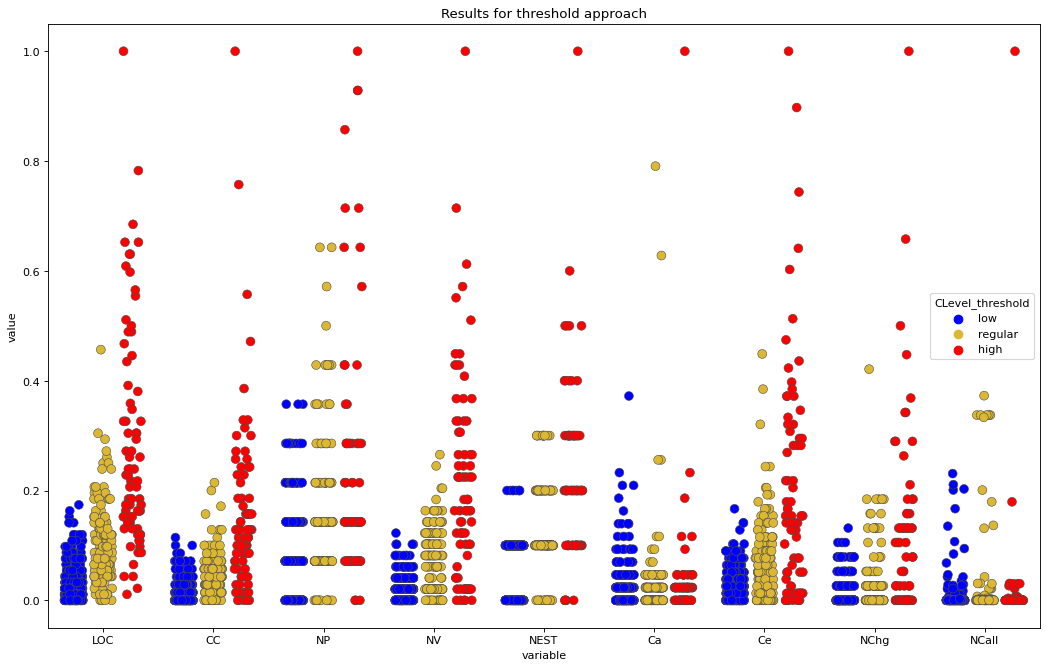

In [10]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(data=df, x='variable', y='value', hue='CLevel_threshold',
              palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
              hue_order=["low", "regular", "high"],
              jitter=0.25, size=8, ax=ax, linewidth=.5, dodge=True)
plt.title('Results for threshold approach')
plt.show()

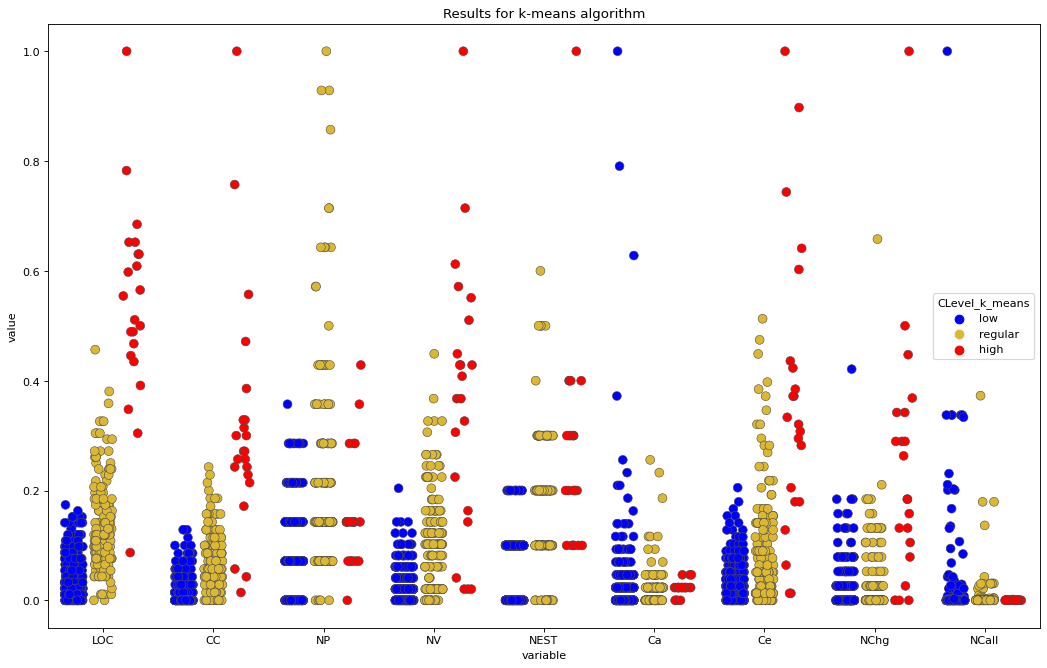

In [11]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(data=df, x='variable', y='value', hue='CLevel_k_means',
              palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
              hue_order=["low", "regular", "high"],
              jitter=0.25, size=8, ax=ax, linewidth=.5, dodge=True)
plt.title('Results for k-means algorithm')
plt.show()

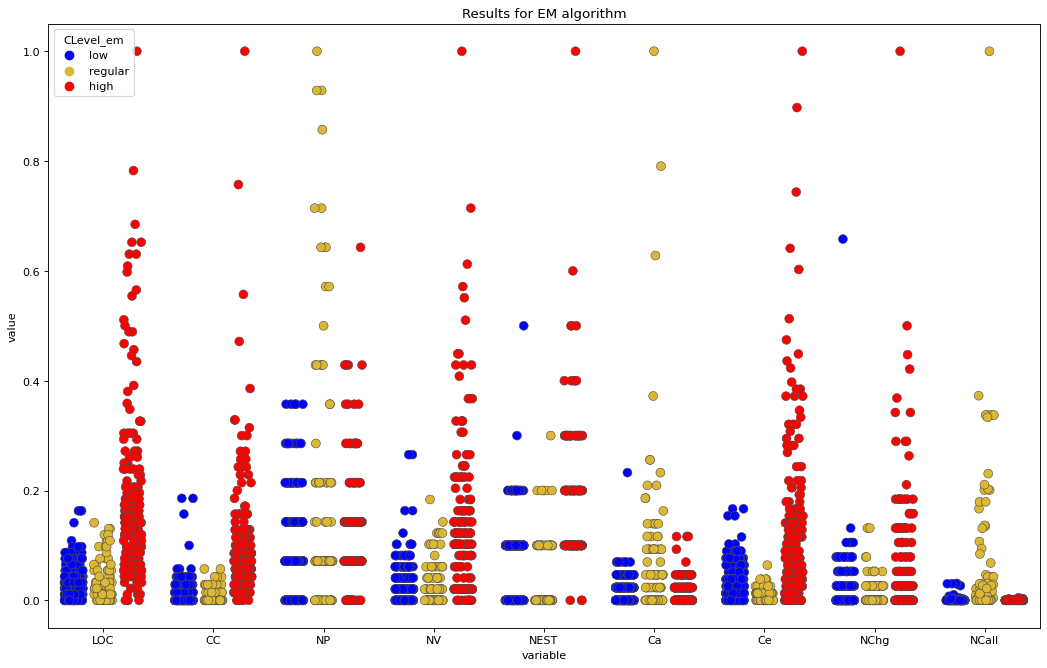

In [12]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(data=df, x='variable', y='value', hue='CLevel_em',
              palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
              hue_order=["low", "regular", "high"],
              jitter=0.25, size=8, ax=ax, linewidth=.5, dodge=True)
plt.title('Results for EM algorithm')
plt.show()

In [13]:
test_data = pd.read_csv(test_cov_file, sep=';')

data_combined = pd.merge(all_labels[str_cols], test_data, on='Method', how='left')

data_combined.isna().sum()

Method               0
CLevel_threshold     0
CLevel_k_means       0
CLevel_em            0
TotalStatements      0
CoveredStatements    0
dtype: int64

Result for threshold approach
low: 0.2099612287503728  regular: 0.13130081300813007  high: 0.09636545515171724  test coverage percetange
Methods number {'Low critical': 563, 'Regular critical': 161, 'High critical': 80}


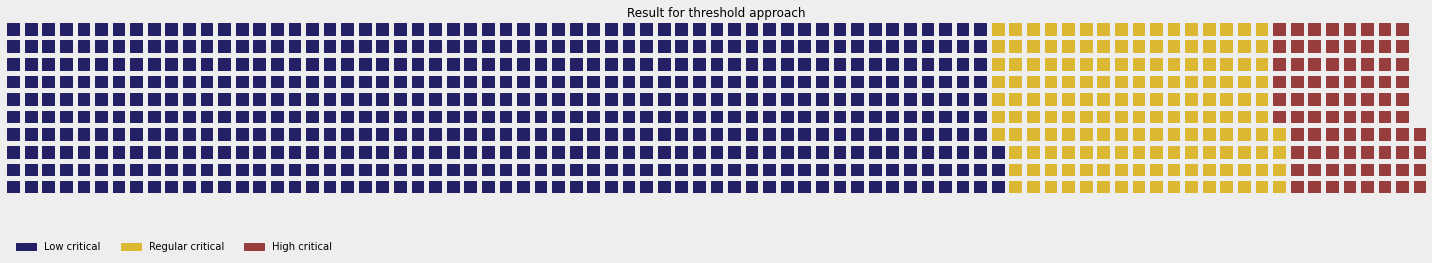

In [14]:
from pywaffle import Waffle

print('Result for threshold approach')

low_ = data_combined[data_combined['CLevel_threshold'] == "low"]
regular_ = data_combined[data_combined['CLevel_threshold'] == "regular"]
high_ = data_combined[data_combined['CLevel_threshold'] == "high"]

l_p = low_['CoveredStatements'].sum()/low_['TotalStatements'].sum()
r_p = regular_['CoveredStatements'].sum()/regular_['TotalStatements'].sum()
h_p = high_['CoveredStatements'].sum()/high_['TotalStatements'].sum()

print('low: {}  regular: {}  high: {}  test coverage percetange'.format(l_p, r_p, h_p))

data = {'Low critical': low_.shape[0], 'Regular critical': regular_.shape[0], 'High critical': high_.shape[0]}
print('Methods number', data)

fig = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    values=data, 
    colors=("#232066", "#DCB732", "#983D3D"),
    labels=['Low critical', 'Regular critical', 'High critical'],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    interval_ratio_x=0.5,
    interval_ratio_y=0.5,
    figsize=(20,10)
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('#EEEEEE')
plt.title('Result for threshold approach')
plt.show()

Result for k_means algorithm
low: 0.2002503128911139  regular: 0.13485166317051245  high: 0.0445945945945946  test coverage percetange
Methods number {'Low critical': 617, 'Regular critical': 165, 'High critical': 22}


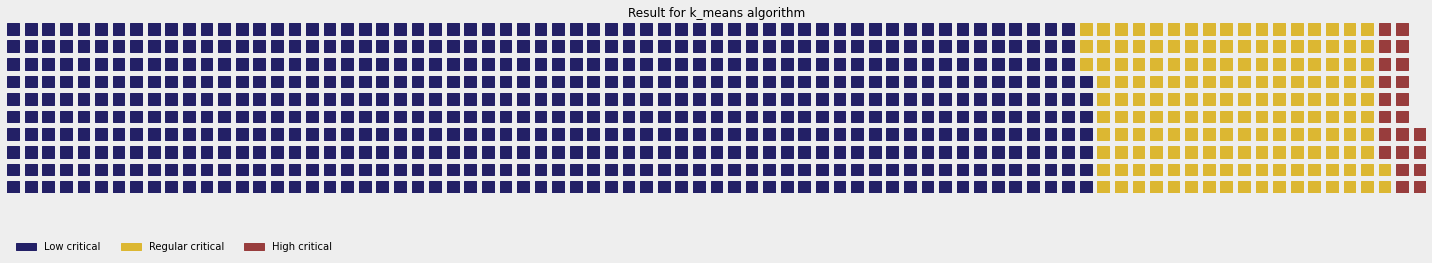

In [15]:
print('Result for k_means algorithm')

low_ = data_combined[data_combined['CLevel_k_means'] == "low"]
regular_ = data_combined[data_combined['CLevel_k_means'] == "regular"]
high_ = data_combined[data_combined['CLevel_k_means'] == "high"]

l_p = low_['CoveredStatements'].sum()/low_['TotalStatements'].sum()
r_p = regular_['CoveredStatements'].sum()/regular_['TotalStatements'].sum()
h_p = high_['CoveredStatements'].sum()/high_['TotalStatements'].sum()

print('low: {}  regular: {}  high: {}  test coverage percetange'.format(l_p, r_p, h_p))


data = {'Low critical': low_.shape[0], 'Regular critical': regular_.shape[0], 'High critical': high_.shape[0]}
print('Methods number', data)

fig = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    values=data, 
    colors=("#232066", "#DCB732", "#983D3D"),
    labels=['Low critical', 'Regular critical', 'High critical'],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    interval_ratio_x=0.5,
    interval_ratio_y=0.5,
    figsize=(20,10)
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('#EEEEEE')
plt.title('Result for k_means algorithm')
plt.show()

Result for EM algorithm
low: 0.18282009724473258  regular: 0.37333333333333335  high: 0.10298420128730251  test coverage percetange
Methods number {'Low critical': 515, 'Regular critical': 88, 'High critical': 201}


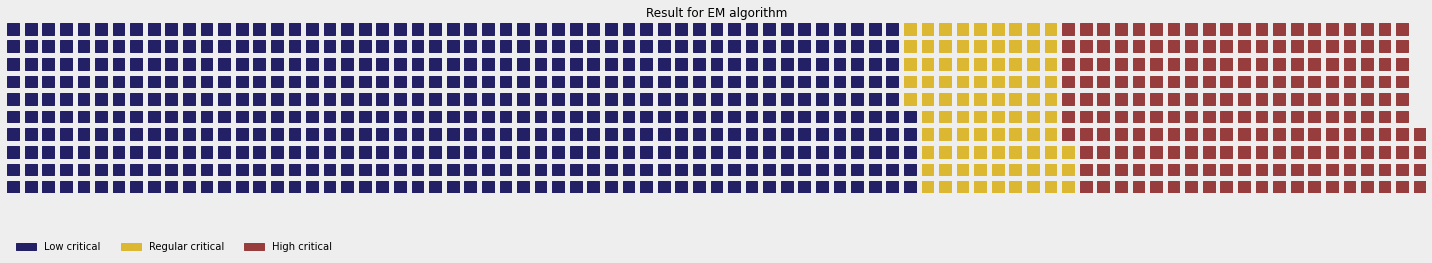

In [16]:
print('Result for EM algorithm')

low_ = data_combined[data_combined['CLevel_em'] == "low"]
regular_ = data_combined[data_combined['CLevel_em'] == "regular"]
high_ = data_combined[data_combined['CLevel_em'] == "high"]

l_p = low_['CoveredStatements'].sum()/low_['TotalStatements'].sum()
r_p = regular_['CoveredStatements'].sum()/regular_['TotalStatements'].sum()
h_p = high_['CoveredStatements'].sum()/high_['TotalStatements'].sum()

print('low: {}  regular: {}  high: {}  test coverage percetange'.format(l_p, r_p, h_p))


data = {'Low critical': low_.shape[0], 'Regular critical': regular_.shape[0], 'High critical': high_.shape[0]}
print('Methods number', data)

fig = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    values=data, 
    colors=("#232066", "#DCB732", "#983D3D"),
    labels=['Low critical', 'Regular critical', 'High critical'],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    interval_ratio_x=0.5,
    interval_ratio_y=0.5,
    figsize=(20,10)
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('#EEEEEE')
plt.title('Result for EM algorithm')
plt.show()